In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preparing-celib-data/first_50_classes_resized_224x224.pkl
/kaggle/input/preparing-celib-data/__results__.html
/kaggle/input/preparing-celib-data/first_50_classes_resized_112x112.pkl
/kaggle/input/preparing-celib-data/__notebook__.ipynb
/kaggle/input/preparing-celib-data/__output__.json
/kaggle/input/preparing-celib-data/custom.css
/kaggle/input/preparing-celib-data/__results___files/__results___11_0.png
/kaggle/input/casia-dataset-pkl/casia_webface_part_minv.pkl


In [2]:
import tensorflow as tf
import time
import pickle

In [3]:


# Path to the saved file
input_file = "/kaggle/input/casia-dataset-pkl/casia_webface_part_minv.pkl"

# Load the data
with open(input_file, "rb") as f:
    loaded_data = pickle.load(f)

# Access the loaded images and labels
images = loaded_data["images"]
labels = loaded_data["labels"]


In [4]:
images = np.array(images)
labels = np.array(labels)

print(images.shape)
print(labels.shape)
# print(set(labels))
#no 28

(10000, 112, 112, 3)
(10000,)


### split

#### normalize float32

In [5]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Normalize images in batches and ensure float32
def normalize_images_in_batches(images, batch_size=50):
    # Normalize to [0, 1] range by dividing by 255 (if images are in the range [0, 255])
    return (images.astype(np.float32)) / 255.0



# Normalize images
normalized_images = normalize_images_in_batches(images, batch_size=100)



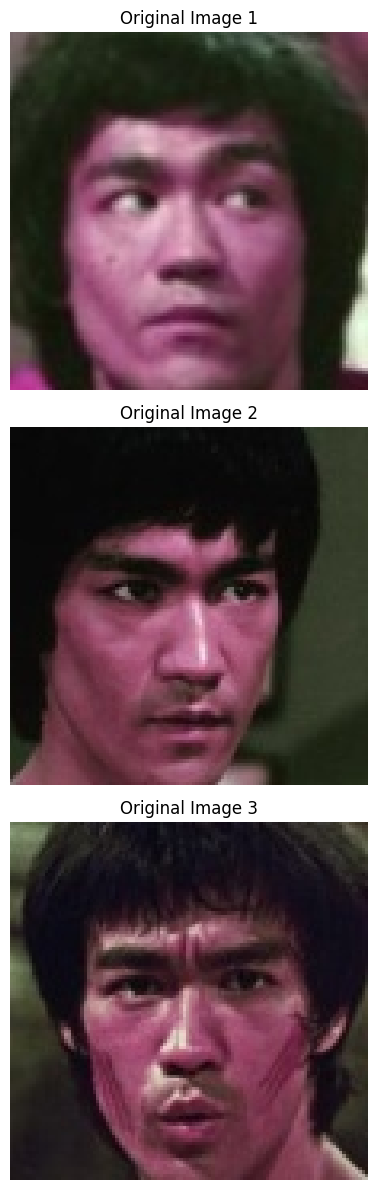

In [6]:
import matplotlib.pyplot as plt

def visualize_original_and_normalized(original_images, normalized_images, num_images=5):
    """
        original_images (np.ndarray): Array of original images.
        normalized_images (np.ndarray): Array of normalized images.
        num_images (int): Number of images to visualize.
    """
    plt.figure(figsize=(10, 4 * num_images))

    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(original_images[i])
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
visualize_original_and_normalized(images, normalized_images, num_images=3)


In [7]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assuming `images` and `labels` are the dataset in uint8

print(f"Original Data Type: {normalized_images.dtype}, Shape: {normalized_images.shape}")

# Split the data
train_images, temp_images, train_labels, temp_labels = train_test_split(
    normalized_images, labels, test_size=0.2, random_state=42
)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42
)


Original Data Type: float32, Shape: (10000, 112, 112, 3)


## clear Memory

In [8]:
# images = []
# normalized_images = []
temp_labels= []
temp_images = []

In [9]:
# assert train_images.shape == train_labels.shape
# assert val_images.shape == val_labels.shape
# assert test_images.shape == test_labels.shape

print(f"Train Images Shape: {train_images.shape}")
print(f"Validation Images Shape: {val_images.shape}")
print(f"Test Images Shape: {test_images.shape}")



Train Images Shape: (8000, 112, 112, 3)
Validation Images Shape: (1000, 112, 112, 3)
Test Images Shape: (1000, 112, 112, 3)


## ready 32

#### define data for tensor

In [10]:


# Prepare TensorFlow datasets
batch_size = 16
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images, train_images))
    .batch(batch_size)
    .shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((val_images, val_images))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_images, test_images))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# trainer + Model

## accuracy

In [13]:
def reconstruction_accuracy(y_true, y_pred, threshold=0.05):
    """Calculates reconstruction accuracy based on a threshold."""
    flat_input_shape = tf.reduce_prod(tf.shape(y_true)[1:])  # Flattened pixel count
    y_true_reshaped = tf.reshape(y_true, (-1, flat_input_shape))
    y_pred_reshaped = tf.reshape(y_pred, (-1, flat_input_shape))
    absolute_diff = tf.abs(y_true_reshaped - y_pred_reshaped)
    correct_pixels = tf.reduce_sum(tf.cast(absolute_diff < threshold, tf.float32), axis=1)
    total_pixels = tf.cast(flat_input_shape, tf.float32)  # Ensure matching types
    accuracy = tf.reduce_mean(correct_pixels / total_pixels)
    return accuracy



##  MLP

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


input_shape = (112, 112, 3)  # Maintain 3D input shape
latent_dim = 64  # Latent space size (tunable)

model = models.Sequential([
    # Encoder
    layers.Input(shape=input_shape),
    layers.Dense(512, activation='relu'),  # Apply Dense layers spatially
    layers.Dense(256, activation='relu'),
    layers.Dense(latent_dim, activation='relu'),
    
    # Decoder
    layers.Dense(256, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(3, activation='sigmoid'),  # Output channels to match input
    layers.Reshape(input_shape)  # Reshape back to original input shape
])

# Compile the model
mlp_autoenc = model.compile(optimizer='adam', loss='mse', metrics=['accuracy',reconstruction_accuracy])

epoch = 5

# Train the model
history = model.fit(
    train_dataset,  # Input and output are the same
    validation_data=val_dataset,
    epochs=epoch,  # Tune based on performance
    batch_size=30
)

# Evaluate on test data
test_loss = model.evaluate(test_dataset)
print(f"Test data: {test_loss}")


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 95s 161ms/step - accuracy: 0.9098 - loss: 0.0112 - val_accuracy: 0.9141 - val_loss: 9.5872e-05
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 169ms/step - accuracy: 0.9432 - loss: 7.7256e-05 - val_accuracy: 0.9581 - val_loss: 3.2617e-05
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 168ms/step - accuracy: 0.9537 - loss: 3.6093e-05 - val_accuracy: 0.9870 - val_loss: 1.1548e-05
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 168ms/step - accuracy: 0.9546 - loss: 2.1297e-05 - val_accuracy: 0.9313 - val_loss: 7.5374e-06
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 168ms/step - accuracy: 0.9520 - loss: 3.3284e-05 - val_accuracy: 0.9279 - val_loss: 7.2326e-06
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9339 - loss: 7.9660e-06
Test data: [7.756808372505475e-06, 0.9264768958091736]


## Convolutional_model

In [12]:
import tensorflow as tf

def convolutional_autoencoder_v2(input_shape):
    # Encoder
    print(f"Input shape: {input_shape}")
    inputs = tf.keras.Input(shape=input_shape)

    # Convolutional Encoder
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x)  # Replaced MaxPooling2D

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x)  # Replaced MaxPooling2D

    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x)  # Replaced MaxPooling2D

    # Latent Space
    latent_space = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="latent_space")(x)

    # Convolutional Decoder
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(latent_space)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    # Output Layer
    outputs = tf.keras.layers.Conv2DTranspose(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    # Define the autoencoder and encoder models
    autoencoder = tf.keras.Model(inputs, outputs, name="Vanilla_Autoencoder")
    encoder = tf.keras.Model(inputs, latent_space, name="Encoder")

    return autoencoder, encoder


In [14]:
print("original")
# Instantiate and compile the autoencoder
input_shape = (112,112,3)
conv_autoencoder , conv_encoder = convolutional_autoencoder_v2(input_shape=input_shape)
conv_autoencoder.compile(optimizer='adam', loss='mae', metrics=['accuracy',reconstruction_accuracy]) # mean square error

start_time = time.time()
# Train the autoencoder
epochs = 8
conv_history = conv_autoencoder.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=5,
    verbose=1
)

# Evaluate the model on the test set
test_loss = conv_autoencoder.evaluate(test_dataset)
print(f"Test data: {test_loss}")
# print(f"Test Accuracy: {test_accuracy:.4f}")

# Define the file path
log_file = '/kaggle/working/training_logs/training_history.txt'
# Ensure the directory exists
import os
os.makedirs(os.path.dirname(log_file), exist_ok=True)

# Append the history to the file
with open(log_file, 'a') as f:
    f.write(f"Training for conolution\n")
    f.write(f"Epochs: {len(conv_history.history['loss'])}\n")
    f.write(f"Training Loss: {conv_history.history['loss']}\n")
    f.write(f"Validation Loss: {conv_history.history['val_loss']}\n")
    f.write(f"time: {time.time()-start_time}\n")
    f.write("-" * 25 + "\n")
print(f"Training history appended to {log_file}!")

# old =0.67 for epoch 3
# 0.75 epoch 10

original
Input shape: (112, 112, 3)
Epoch 1/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.8960 - loss: 0.0924 - reconstruction_accuracy: 0.4679 - val_accuracy: 0.8840 - val_loss: 0.0351 - val_reconstruction_accuracy: 0.7780
Epoch 2/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9117 - loss: 0.0357 - reconstruction_accuracy: 0.7704 - val_accuracy: 0.8726 - val_loss: 0.0320 - val_reconstruction_accuracy: 0.8117
Epoch 3/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9190 - loss: 0.0292 - reconstruction_accuracy: 0.8368 - val_accuracy: 0.8559 - val_loss: 0.0306 - val_reconstruction_accuracy: 0.8232
Epoch 4/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9212 - loss: 0.0271 - reconstruction_accuracy: 0.8574 - val_accuracy: 0.9294 - val_loss: 0.0234 - val_reconstruction_accuracy: 0.8875
Epoch 5/8
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9218 - loss: 0.0249 - reconstruction_accuracy: 0.8779 - val_accuracy: 0.9211 - val_loss: 0.02

## data of models



### show loss conv

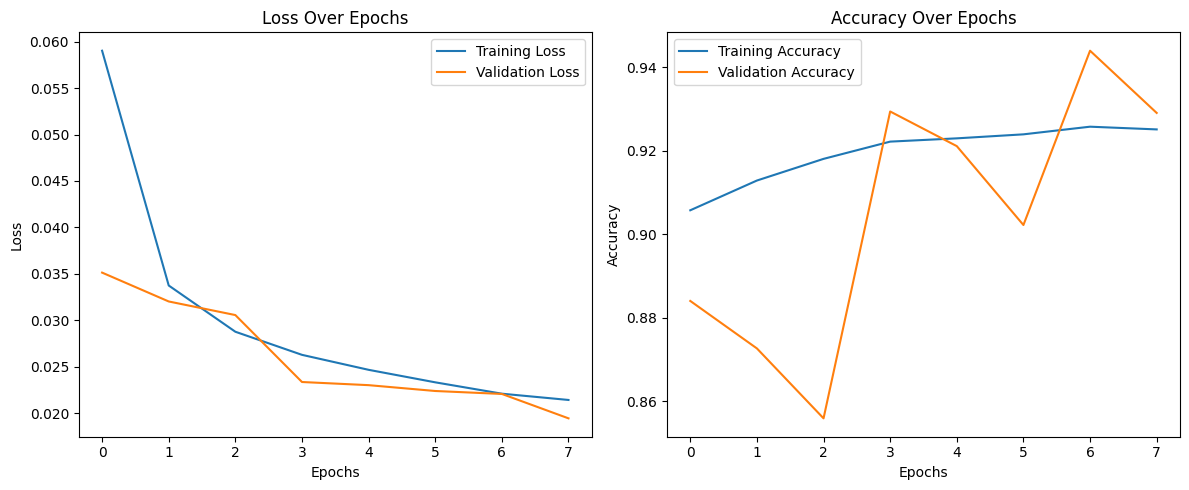

In [22]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(conv_history.history['loss'], label='Training Loss')
plt.plot(conv_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(conv_history.history['accuracy'], label='Training Accuracy')
plt.plot(conv_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Display plots
plt.tight_layout()
plt.show()


### MLP draw

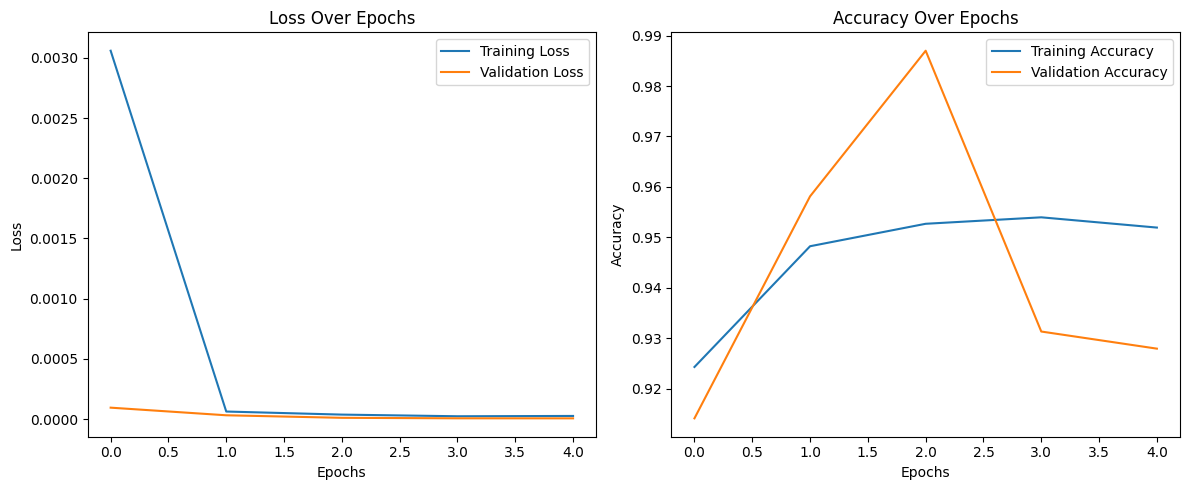

In [23]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Display plots
plt.tight_layout()
plt.show()


## Calculate accuracy with classifier

In [16]:
import numpy as np

def calculate_accuracy(predicted_images, normalized_images, labels):
    """
    Calculate accuracy by matching predicted images to normalized images and checking labels.

        predicted_images (np.ndarray): Array of predicted/reconstructed images.
        normalized_images (np.ndarray): Array of normalized input images.
        labels (np.ndarray): Array of true labels corresponding to normalized images.

    """
    # assert predicted_images.shape == normalized_images.shape, "Shape mismatch between predicted and normalized images."
    # assert len(labels) == len(normalized_images), "Mismatch between labels and normalized images."
    
    # Initialize counters
    idx= []
    correct_matches = 0
    total_images = len(predicted_images)

    # Loop through each predicted image
    for i, predicted in enumerate(predicted_images):
        if i%200==0:
            print(i)
        # Calculate the pixel-wise mean squared error with all normalized images
        errors = np.mean((normalized_images - predicted) ** 2, axis=(1, 2, 3))
        
        # Find the closest normalized image
        closest_index = np.argmin(errors)
        
        # If the closest match is below the threshold, check the labels
        if labels[closest_index] == labels[i]:
            correct_matches += 1
            idx.append(i)
            

    # Calculate accuracy
    accuracy = (correct_matches / total_images) * 100
    return accuracy, idx


# Eigen faces

In [17]:
import numpy as np
import cv2
from sklearn.metrics import accuracy_score

# Load and preprocess data
def preprocess_images(images):
    resized_images = [cv2.resize(img, (64, 64)) for img in images]
    gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in resized_images]
    flattened_images = [img.flatten() for img in gray_images]
    return np.array(flattened_images)

# Compute Eigenfaces
def compute_eigenfaces(data, n_components):
    mean_face = np.mean(data, axis=0)
    centered_data = data - mean_face
    covariance_matrix = np.dot(centered_data.T, centered_data)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    sorted_indices = np.argsort(-eigenvalues)
    top_eigenvectors = eigenvectors[:, sorted_indices[:n_components]]
    return mean_face, top_eigenvectors

# Project data onto PCA space
def project_to_pca_space(data, mean_face, eigenfaces):
    centered_data = data - mean_face
    projections = np.dot(centered_data, eigenfaces)
    return projections

# Classify using nearest neighbor
def nearest_neighbor_classifier(train_projections, train_labels, test_projection):
    distances = np.linalg.norm(train_projections - test_projection, axis=1)
    return train_labels[np.argmin(distances)]

# Main workflow

data = preprocess_images(images)
mean_face, eigenfaces = compute_eigenfaces(data, n_components=50)

# Split the data
train_data, test_data, train_labels_v2, test_labels_v2 = train_test_split(
    data, labels, test_size=0.2, random_state=42
)



train_projections = project_to_pca_space(train_data, mean_face, eigenfaces)
test_projections = project_to_pca_space(test_data, mean_face, eigenfaces)

# Classify and evaluate
predictions = [nearest_neighbor_classifier(train_projections, train_labels_v2, test_proj) for test_proj in test_projections]
accuracy = accuracy_score(test_labels_v2, predictions)

print("Recognition Accuracy:", accuracy)


Recognition Accuracy: 0.328


### Calculate accuracy for convolutional

In [18]:
# Predict normalized images using the trained autoencoder
train_images_latent_conv = conv_encoder.predict(train_images, batch_size=32, verbose=1)
test_images_latent_conv = conv_encoder.predict(test_images, batch_size=32, verbose=1)

# Verify the shape of the predicted images
print(f"Predicted Images Shape: {train_images_latent_conv.shape}")
print(f"Predicted Images Shape: {test_images_latent_conv.shape}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted Images Shape: (8000, 14, 14, 64)
Predicted Images Shape: (1000, 14, 14, 64)


## using svm

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

 # Reshape the 4D image arrays into 2D arrays
train_images_reshaped = train_images_latent_conv.reshape(train_images_latent_conv.shape[0], -1)
test_images_reshaped = test_images_latent_conv.reshape(test_images_latent_conv.shape[0], -1)

# Initialize the SVM classifier with a radial basis function kernel (default)
svm_classifier = SVC(kernel='rbf')

# Train the classifier
svm_classifier.fit(train_images_reshaped, train_labels)
#1:12

# Make predictions on the test set
y_pred = svm_classifier.predict(test_images_reshaped)
print(test_labels.shape)
print(y_pred.shape)

print(test_labels.shape)
print(y_pred.shape)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


(1000,)
(1000,)
(1000,)
(1000,)
Accuracy: 53.30%


# mlp acc

In [21]:
# Predict normalized images using the trained autoencoder
train_images_latent_mlp = model.predict(train_images, batch_size=32, verbose=1)
test_images_latent_mlp = model.predict(test_images, batch_size=32, verbose=1)

# Verify the shape of the predicted images
print(f"Predicted Images Shape: {train_images_latent_conv.shape}")
print(f"Predicted Images Shape: {test_images_latent_conv.shape}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step
Predicted Images Shape: (8000, 14, 14, 64)
Predicted Images Shape: (1000, 14, 14, 64)


In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

 # Reshape the 4D image arrays into 2D arrays
train_images_reshaped = train_images_latent_mlp.reshape(train_images_latent_mlp.shape[0], -1)
test_images_reshaped = test_images_latent_mlp.reshape(test_images_latent_mlp.shape[0], -1)

# Initialize the SVM classifier with a radial basis function kernel (default)
svm_classifier = SVC(kernel='rbf')

# Train the classifier
svm_classifier.fit(train_images_reshaped, train_labels)
#1:12



# Make predictions on the test set
y_pred = svm_classifier.predict(test_images_reshaped)
print(test_labels.shape)
print(y_pred.shape)

print(test_labels.shape)
print(y_pred.shape)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


(1000,)
(1000,)
(1000,)
(1000,)
Accuracy: 50.40%


## misc

In [ ]:
# max acc = 56 for svm 
# model acc = 45